# ATMS 523 Module 4 Homework

## SeungUk Kim

Adopted some codes from Module4, Notebook5 from class.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.standard import Eof

### Part 1 & 2

* Use downloaded sst, tp, and lsm from [cds.climate.copernicus.eu](cds.climate.copernicus.eu) for consistent grid
* Selected the Pacific domain, deseasonalized and saved data
* Detrended and standardized data

In [2]:
lsm = xr.open_dataset('lsm.nc').isel(time=0)

In [3]:
ds = xr.open_dataset('./sst_pp.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 521, time: 516)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-12 01:12:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
# Mask out land for precip data
ds['tp'] = ds['tp'] * (lsm.lsm.squeeze() == 0)

In [5]:
# Select the Pacific domain
longr = np.append(np.linspace(-180,-60,481), np.linspace(120,179.75,240))
ds_pac = ds.sel(longitude=longr)

In [6]:
# Deseasonalize data
ds_pac['tp'] = ds_pac.tp.groupby('time.month') - ds_pac.tp.groupby('time.month').mean()
ds_pac['sst'] = ds_pac.sst.groupby('time.month') - ds_pac.sst.groupby('time.month').mean()

In [7]:
ds_pac.to_netcdf('sst_pp_anom_Pacific.nc')

In [2]:
# ds_pac = xr.open_dataset('sst_pp_anom_Pacific.nc')

In [8]:
# Detrend SST
p_sst = ds_pac.sst.polyfit(dim='time', deg=1)
sst_trd = xr.polyval(ds_pac.time, p_sst.polyfit_coefficients)
sst_dtrd = ds_pac.sst - sst_trd
# Detrend TP
p_tp = ds_pac.tp.polyfit(dim='time', deg=1)
tp_trd = xr.polyval(ds_pac.time, p_tp.polyfit_coefficients)
tp_dtrd = ds_pac.tp - tp_trd

In [9]:
# Standardize SST
det_mon_grp = sst_dtrd.groupby('time.month')
sst_std_ano = xr.apply_ufunc(lambda x, m, s: (x-m)/s, det_mon_grp, det_mon_grp.mean('time'), det_mon_grp.std('time'))

In [10]:
# Standardize TP
det_mon_grp = tp_dtrd.groupby('time.month')
tp_std_ano = xr.apply_ufunc(lambda x, m, s: (x-m)/s, det_mon_grp, det_mon_grp.mean('time'), det_mon_grp.std('time'))

<ipython-input-10-1ca7fc79a9f0>:3: RuntimeWarning: invalid value encountered in true_divide
  tp_std_ano = xr.apply_ufunc(lambda x, m, s: (x-m)/s, det_mon_grp, det_mon_grp.mean('time'), det_mon_grp.std('time'))
<ipython-input-10-1ca7fc79a9f0>:3: RuntimeWarning: invalid value encountered in true_divide
  tp_std_ano = xr.apply_ufunc(lambda x, m, s: (x-m)/s, det_mon_grp, det_mon_grp.mean('time'), det_mon_grp.std('time'))
<ipython-input-10-1ca7fc79a9f0>:3: RuntimeWarning: invalid value encountered in true_divide
  tp_std_ano = xr.apply_ufunc(lambda x, m, s: (x-m)/s, det_mon_grp, det_mon_grp.mean('time'), det_mon_grp.std('time'))
<ipython-input-10-1ca7fc79a9f0>:3: RuntimeWarning: invalid value encountered in true_divide
  tp_std_ano = xr.apply_ufunc(lambda x, m, s: (x-m)/s, det_mon_grp, det_mon_grp.mean('time'), det_mon_grp.std('time'))
<ipython-input-10-1ca7fc79a9f0>:3: RuntimeWarning: invalid value encountered in true_divide
  tp_std_ano = xr.apply_ufunc(lambda x, m, s: (x-m)/s, det_mon_g

### Part 3 & 4

* EOF Analysis using `eofs.standard`
* `eofs.xarray raised` error when reconstructing
* Five leading EOFs on map
* Explained variances by ten leading EOFs

In [11]:
# Get latitude weight
coslat = np.cos(np.deg2rad(sst_std_ano['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

In [12]:
# EOF Analysis
solver = Eof(sst_std_ano.data, weights=wgts)
pcs = solver.pcs(npcs=1)
eof5 = solver.eofsAsCorrelation(neofs=5)
varex = solver.varianceFraction()*100

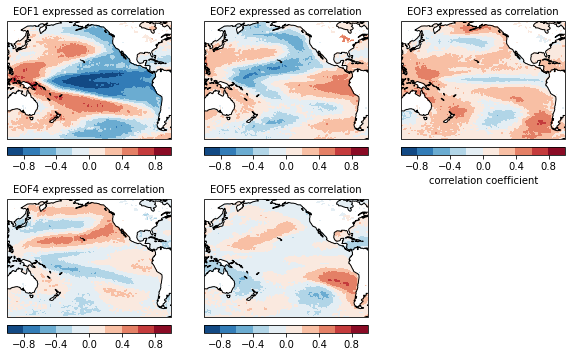

In [20]:
# Five leading EOFs expressed as correlation
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,6),
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=190)})
clevs = np.linspace(-1, 1, 11)

for i, ax in enumerate(fig.axes):
    if i == 5:
        ax.axis('off')
        break
    ax.coastlines()
    ax.set_title('EOF%d expressed as correlation' % (i+1), fontsize=10)
    ax.set_extent([120, 300, -65, 65], ccrs.PlateCarree())
    fill = ax.contourf(ds_pac.longitude, ds_pac.latitude, eof5[i,:,:],
                       levels=clevs, cmap=plt.cm.RdBu_r,
                       transform=ccrs.PlateCarree())
    cb = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
    if i == 2:
        cb.set_label('correlation coefficient', fontsize=10)

(3.1081751957505718e-31, 19.00635468292892)

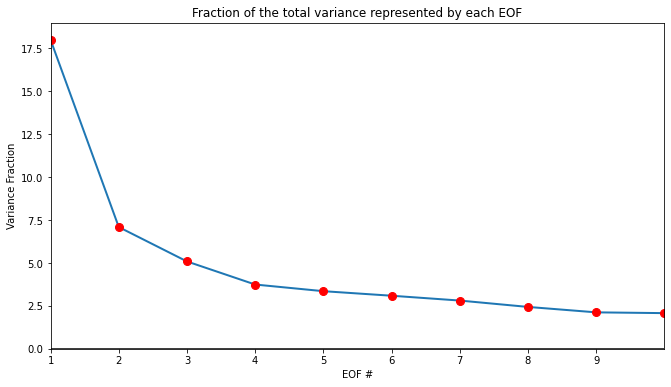

In [21]:
# Fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varex[0:10], linewidth=2)
plt.plot(eof_num, varex[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 10))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varex), np.max(varex)+1)

### Part 5 & 6

* Reconstructing SST anomalies
* Correlation between reconstructed and observed SST
* Correlation between EOF1 and standardized TP

In [23]:
# Reconstruction using five EOFs
reconstruction = solver.reconstructedField(5)
recon_da = sst_std_ano
recon_da.data = reconstruction

In [24]:
# Correlation of SSTs
sst_corr = xr.corr(recon_da, ds_pac.sst, dim='time')

Text(0.5, 1.0, 'Reconstructed vs. Observation')

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


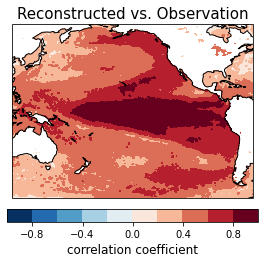

In [25]:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = sst_corr.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                              add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.set_extent([120, 300, -65, 65], ccrs.PlateCarree())
cb = plt.colorbar(fill, orientation='horizontal', pad=0.05, shrink=0.75)
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('Reconstructed vs. Observation', fontsize=15)

In [26]:
# PC1 with time dimension
pcs_da = xr.DataArray(data=pcs.squeeze(), dims=["time"], coords=dict(time=ds_pac.time))

In [27]:
# Correlation between PC1 (EOF1) and standardized TP
tp_eof1_corr = xr.corr(pcs_da, tp_std_ano, dim='time')

Text(0.5, 1.0, 'EOF1 vs. Precipitation')

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


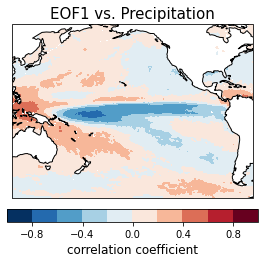

In [28]:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = tp_eof1_corr.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                  add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.set_extent([120, 300, -65, 65], ccrs.PlateCarree())
cb = plt.colorbar(fill, orientation='horizontal', pad = 0.05, shrink=0.75)
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 vs. Precipitation', fontsize=15)

Correlation between the principal component of EOF1 and precipitation shows similar pattern of precipitation during ENSO.